# Balancing a "cart-pole" inverse pendulum using NESTML

In this tutorial, we are going to build an agent that can successfully solve the classic pole balancing problem using reinforcement learning. We will start with a standard temporal difference learning approach and after that, use NESTML to set up a spiking neural network to perform this task.

# Cart Pole Environment

For the cart pole environment, we mostly need three things:  
    - A renderer to display the simulation  
    - The physics system and  
    - An input to be able to nudge the pole in both directions  

For that, we will need the following packages:

In [11]:
%matplotlib inline

from typing import Tuple

import sys
import pygame as pg
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

import nest

nest.set_verbosity("M_ERROR")

DEBUG:Loaded backend module://matplotlib_inline.backend_inline version unknown.


## Physics of the inverse pendulum

For the physics, we use the corrected version of of the original problem derived from V. Florian (CITATION NEEDED), but omit the friction forces.
The situation is sketched here:  

![alt text](cartpole_illustration.png "Cartpole")

We apply Newton's second law of motion to the cart:  
$$
\begin{aligned}
    \mathbf{F} + \mathbf{G}_c - \mathbf{N} = m_c \cdot \mathbf{a}_c
\end{aligned}
$$
Where:  

$\mathbf{F} = F \cdot \mathbf{u_x}$ is the control force acting on the cart,  
$\mathbf{G}_c = m_c \cdot g \cdot \mathbf{u}_y$ is the gravitational component acting on the cart,  
$\mathbf{N} = N_x \cdot \mathbf{u}_x - N_y \cdot \mathbf{u}_y$ is the negative reaction force that the pole is applying on the cart,  
$\mathbf{a}_c = \ddot{x} \cdot \mathbf{u}_x$ is the accelaration of the cart,  
$m_c$ is the cart's mass and  
$\mathbf{u}_x$, $\mathbf{u}_y$, $\mathbf{u}_z$ are the unit vectors of the frame of reference given in the illustration.

We can decompose this equation now into the $x$ and $y$ component:
$$
\begin{aligned}
    F - N_x = m_c \cdot \ddot{x}
\end{aligned}
$$
$$
\begin{aligned}
    m_c \cdot g + N_y = 0
\end{aligned}
$$

Newton's second law of motion applied to the pole gives us:
$$
\begin{aligned}
    \mathbf{N} + \mathbf{G}_p = m_p \cdot \mathbf{a}_p
\end{aligned}
$$

Where $\mathbf{G}_p = m_p \cdot g \cdot \mathbf{u}_y$.

The accelaration $\mathbf{a}_p$ of the pole's center of mass consists of three components, where $\mathbf{r}_p = l \cdot (\sin{\theta}\cdot \mathbf{u}_x-\cos{\theta}\cdot \mathbf{u}_y)$ denotes the vector pointing to the pole's center of mass relative to it's rotation center:  
1. The accelaration of the cart it is attached to $\mathbf{a}_c$,
2. The pole's angular accelaration $\mathbf{\epsilon} = \ddot{\theta} \cdot \mathbf{u}_z$, which is translated into accelaration by $\mathbf{\epsilon} \times \mathbf{r}_p$.
3. The pole's angular velocity $\mathbf{\omega} = \dot{\theta} \cdot \mathbf{u}_z$, for which the accelaration can be derived by  $\mathbf{\omega} \times (\mathbf{\omega} \times \mathbf{r}_p)$.

Thus we obtain:
$$
\begin{aligned}
    \mathbf{a}_p  = \mathbf{a}_c + \mathbf{\epsilon} \times \mathbf{r}_p + \mathbf{\omega} \times (\mathbf{\omega} \times \mathbf{r}_p)
\end{aligned}
$$
Substituting $\mathbf{r}_p = l \cdot (\sin{\theta}\cdot \mathbf{u}_x-\cos{\theta}\cdot \mathbf{u}_y)$ and $\mathbf{a}_p = \ddot{x} \cdot \mathbf{u}_x$ as well as $\mathbf{u}_z \times \mathbf{u}_x = \mathbf{u}_y$ and $\mathbf{u}_z \times \mathbf{u}_y = -\mathbf{u}_x$:
\begin{aligned}
    \mathbf{a}_p  = \ddot{x} \cdot \mathbf{u}_x + l \cdot \ddot{\theta} \cdot (\sin{\theta}\cdot \mathbf{u}_y + \cos{\theta}\cdot \mathbf{u}_x) - l \cdot \dot{\theta}^2 \cdot (\sin{\theta}\cdot \mathbf{u}_x - \cos{\theta}\cdot \mathbf{u}_y)
\end{aligned}

Inserting this quation into our equation for the forces of the pole and decomposing on the $x$ and $y$ axis we obtain:
$$
\begin{aligned}
    N_x = m_p \cdot (\ddot{x} + l \cdot \ddot{\theta} \cdot \cos{\theta} - l \cdot \dot{\theta}^2 \cdot \sin{\theta})
\end{aligned}
$$
$$
\begin{aligned}
    m_p \cdot g - N_y = m_p \cdot (l \cdot \ddot{\theta} \cdot \sin{\theta} + l \cdot \dot{\theta}^2 \cdot \cos{\theta})
\end{aligned}
$$

To render the environment for visual inspection, we make a class ``Renderer`` that uses pygame:

Physics is implemented in a class ``Physics``:

In [2]:
class Physics():
    
    def __init__(self, x, theta, v = 0, a = 0, w = 0, dw = 0, g = 9.81, m_c = 1, m_p = 0.1, l = 0.5, dt = 0.02) -> None:
        self.__dict__.update(vars())

    def dw_step(self, cart_force, nudge_force) -> float:
        numerator = self.g * np.sin(self.theta) + np.cos(self.theta) * (-cart_force - self.m_p * self.l * self.w**2 * np.sin(self.theta))/(self.m_c+self.m_p) + nudge_force * np.cos(self.theta)/(self.m_p*self.l)
        denominator = self.l * (4/3 - (self.m_p*np.cos(self.theta)**2)/(self.m_c+self.m_p))

        self.dw = numerator/denominator
        self.w += self.dt * self.dw
        self.theta += self.dt * self.w

        return self.theta
    
    def a_step(self, force) -> float:
        numerator = force + self.m_p * self.l * (self.w**2 * np.sin(self.theta) - self.dw * np.cos(self.theta))
        denominator = self.m_c + self.m_p

        self.a = numerator/denominator
        self.v += self.dt * self.a
        self.x += self.dt * self.v

        return self.x

    def update(self, force, mouse_x) -> Tuple[float, float]:
        nudge_force = 0
        if mouse_x is not None:
            nudge_force = -10 if mouse_x > self.x else 10

        return (self.dw_step(force, nudge_force), self.a_step(force))
    
    #get state of the system that agent can see
    def get_state(self) -> Tuple[float,float,float,float]:
        return (self.x, self.theta, self.v, self.w)
    
    def reset(self) -> None:
        self.x = 0
        self.theta = (np.random.rand() - 1) / 10
        self.v = 0
        self.a = 0
        self.w = 0
        self.dw = 0


In [3]:
#Renders the scene. IMPORTANT: Because ipycanvas uses the html canvas coordinates, the y-axis is inverted.
class Renderer():
    def __init__(self, width: int, height: int, origin_x: int = 0, origin_y: int = 0, SCALE: int = 1) -> None:
        self.width = width
        self.height = height
        self.origin = (origin_x, origin_y)
        self.SCALE = SCALE #1m = SCALE pixels

        pg.display.init()
        pg.display.set_caption("Pole Balancing Simulator")
        pg.font.init()
        self.screen = pg.display.set_mode((width, height))
    
    #Translates global coordinates into screen coordinates
    def translate(self, x: int, y: int) -> Tuple[int, int]:
        return (x+self.origin[0], -y+self.origin[1])
    
    #Draws ground. offset is there to shift the ground below the car
    def draw_ground(self, offset: int, color) -> None:
        ground = pg.Rect(self.translate(-self.width//2, -offset * self.SCALE), (self.width, self.height-self.origin[1]-offset * self.SCALE))
        pg.draw.rect(self.screen, color, ground)

    #Draws car. pos_y is omitted because the car's center should be at y = 0
    def draw_car(self, pos_x: float, car_color = "blue", wheel_color = "black") -> None:
        pos_x *= self.SCALE
        #values, hard-coded for now, in meters
        width = 0.5 * self.SCALE
        height = 0.25 * self.SCALE
        wheel_radius = 0.1 * self.SCALE

        car_body = pg.Rect(self.translate(pos_x - width/2, height/2), (width, height))
        pg.draw.rect(self.screen, car_color, car_body)
        pg.draw.circle(self.screen, wheel_color, 
                           self.translate(pos_x - width/2 + wheel_radius, -height/2), wheel_radius)
        pg.draw.circle(self.screen, wheel_color, 
                           self.translate(pos_x + width/2 - wheel_radius, -height/2), wheel_radius)

    #Draws the pole
    def draw_pole(self, pos_x: float, theta: float, length: float, width: float = 0.1, color = "red") -> None:
        pos_x *= self.SCALE
        width = int(width * self.SCALE)
        pole_end_x = length * np.sin(theta) * self.SCALE + pos_x
        pole_end_y = length * np.cos(theta) * self.SCALE
        pg.draw.line(self.screen, color, self.translate(pos_x, 0), self.translate(pole_end_x, pole_end_y), width)

    #Clears the entire canvas
    def draw_clear(self) -> None:
        self.screen.fill("white")

    #Draws physical values
    def draw_stats(self, theta: float, dw: float, a: float, x: float, episode: int) -> None:
        font = pg.font.Font(None, 24)
        text = font.render(str(theta)[:4] + " | " + str(dw)[:4] + " | " + str(x)[:4] + " | " + str(a)[:4] + " | episode: " + str(episode), True, (10,10,10))
        textpos = text.get_rect(centerx=self.screen.get_width() / 2, y=10)
        self.screen.blit(text, textpos)

    #Get the 
    def get_relative_mouse_x(self, mouse_x:float) -> float:
        return (mouse_x-self.origin[0])/self.SCALE
    
    def display(self) -> None:
        pg.display.flip()

Let's see the physics in action (without an agent controlling the cart yet):

In [4]:
r = Renderer(1200, 800, 600, 500, 400)
clock = pg.time.Clock()
running = True

p = Physics(0, (np.random.rand() - 1) / 10)

steps_per_episode = 0
max_steps = 0

while running:
    steps_per_episode += 1

    force = 0
    mouse_x = None

    # poll for events
    for event in pg.event.get():
        if event.type == pg.QUIT:
            running = False
            pg.quit()
            sys.exit()
            quit()
        elif event.type == pg.MOUSEBUTTONDOWN:
            mouse_x = r.get_relative_mouse_x(pg.mouse.get_pos()[0])

    force = 0   # no controller, no action
    theta, x = p.update(force, mouse_x)
    
    r.draw_clear()
    r.draw_ground(0.2, "grey")
    r.draw_car(x)
    r.draw_pole(x, theta, 2*p.l, 0.02)
    r.draw_stats(theta*180/np.pi, p.w*180/np.pi, x, 0, 0)
    r.display()

    clock.tick(50)  # limits FPS to 50


SystemExit: 

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3386: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# The Agent

In the base class ``Agent``...

"boxes" (discretizing the state space)...

In [4]:
class Agent:
    def __init__(self, initial_state: Tuple[float, float, float, float]) -> None:
        self.x_thresholds = np.array([-2.4, -0.8, 0.8, 2.4])
        self.theta_thresholds = np.array([-12, -6, -1, 0, 1, 6, 12])
        self.theta_thresholds = self.theta_thresholds / 180 * np.pi
        self.v_thresholds = np.array([float("-inf"), -0.5, 0.5, float("+inf")]) #open intervals ignored here
        self.w_thresholds = np.array([float("-inf"), -50, 50, float("+inf")]) #open intervals ignored here
        self.w_thresholds = self.w_thresholds /180 * np.pi

        self.dimensions = (len(self.x_thresholds),
                           len(self.theta_thresholds),
                           len(self.v_thresholds),
                           len(self.w_thresholds))

        self.boxes = np.random.rand(self.dimensions[0], 
                                    self.dimensions[1], 
                                    self.dimensions[2], 
                                    self.dimensions[3], 
                                    2) # one q-value for left and right respectively
        box = self.get_box(initial_state)
        self.current_box = self.boxes[box[0], box[1], box[2], box[3], :]

        self.episode = 1

    def discretize(self, value, thresholds):
        thresholds = np.asarray(thresholds)
        box_idx = np.digitize(value, thresholds)

        if box_idx == 0 or box_idx > len(thresholds) - 1:
            # below the lowest or above the highest threshold
            return -1

        return box_idx - 1
    
    def get_box(self, state: Tuple[float,float,float,float]) -> Tuple[int,int,int,int]:
        return (self.discretize(state[0], self.x_thresholds),
                 self.discretize(state[1], self.theta_thresholds),
                 self.discretize(state[2], self.v_thresholds), 
                 self.discretize(state[3], self.w_thresholds))
    
    def get_episode(self) -> int:
        return self.episode
    
    def failure_reset(self, state: Tuple[float,float,float,float]):
        box = self.get_box(state)
        self.current_box = self.boxes[box[0], box[1], box[2], box[3], :]
        self.episode += 1

Show discretisation:

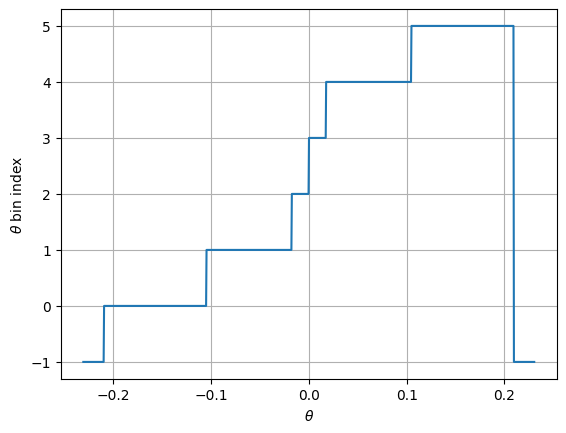

In [5]:
agent = Agent((0,0,0,0))

fig, ax = plt.subplots()
theta_min = np.amin(agent.theta_thresholds)
theta_max = np.amax(agent.theta_thresholds)
theta_range = np.linspace(theta_min - .1 * np.abs(theta_min), theta_max + .1 * np.abs(theta_max), 1000)

theta_idx = np.nan * np.ones_like(theta_range)
for i in range(len(theta_range)):
    theta_idx[i] = agent.discretize(theta_range[i], agent.theta_thresholds)

ax.plot(theta_range, theta_idx)
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\theta$ bin index")
ax.grid(True)

## Non-spiking version

...

In [6]:
class NonSpikingAgent(Agent):
    def __init__(self, initial_state: Tuple[float,float,float,float], learning_rate, learning_decay, epsilon, epsilon_decay, discount_factor) -> None:
        super().__init__(initial_state)

        #learning paramters
        self.learning_rate = learning_rate
        self.learning_decay = learning_decay
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.discount_factor = discount_factor

    def choose_action(self) -> int:
        r"""
        Returns 0 if the action is "left", else "1"
        """
        self.action = np.random.choice([np.argmax(self.current_box), np.argmin(self.current_box)],
                                       p=[1 - self.epsilon, self.epsilon])
        return self.action
    
    def update(self, next_state: Tuple[float,float,float,float]) -> int:
        r"""
        Returns 0 if no failure occured, else 1.
        
        Reward is -1 on failure and 0 otherwise.
        """
        box = self.get_box(next_state)
        if -1 in box:
            # failure occurred
            self.current_box[self.action] += self.learning_rate * -1    # apply negative reward
            return 1
        
        next_box = self.boxes[box[0], box[1], box[2], box[3], :]
        next_q = np.max(next_box)
        self.current_box[self.action] += self.learning_rate * (self.discount_factor * (next_q - self.current_box[self.action]))

        self.current_box = next_box
        self.epsilon *= self.epsilon_decay
        self.learning_rate *= self.learning_decay

        return 0
    

Plot renderer:

In [7]:
#%matplotlib qt
class Non_Spiking_PlotRenderer():
    def __init__(self, init_x = [0], init_y = [0]) -> None:
        #plt.ion()
        #Construct lifetime plot
        self.lifetime_fig, self.lifetime_ax = plt.subplots()
        self.lifetime_ax.set_yscale('log')

        self.x = init_x
        self.y = init_y
        self.max_lifetime = 0
        self.line, = self.lifetime_ax.plot(self.x, self.y)
        self.lifetime_ax.set_xlabel("Episode")
        self.lifetime_ax.set_ylabel("Simulation Steps")
        self.lifetime_ax.set_title("Lifetime Plot")

    def update(self, x, y, boxes) -> None:
        self.x.append(x)
        self.y.append(y)
        self.max_lifetime = max(self.max_lifetime, y)
        self.line.set_data(self.x, self.y)
        self.lifetime_ax.set_xlim(self.x[0], self.x[-1])
        self.lifetime_ax.set_ylim(0, self.max_lifetime)

        self.lifetime_fig.canvas.draw()
        self.lifetime_fig.canvas.flush_events()
        
        display.clear_output(wait=True)
        display.display(self.lifetime_fig)

    def update_q_value_heatmap(self, agent):
        r"""
        Construct heatmap for two parameters
        """
        # Compute the four data arrays that will be plotted.
        data1 = np.mean(a.boxes[:, :, :, :, 0], axis=(2, 3))
        data2 = np.mean(a.boxes[:, :, :, :, 1], axis=(2, 3))
        data3 = np.mean(a.boxes[:, :, :, :, 0], axis=(0, 2)).T
        data4 = np.mean(a.boxes[:, :, :, :, 1], axis=(0, 2)).T

        # Determine the overall min and max from all datasets.
        global_min = min(data1.min(), data2.min(), data3.min(), data4.min())
        global_max = max(data1.max(), data2.max(), data3.max(), data4.max())

        # Use symmetric limits so that zero is centered.
        limit = max(abs(global_min), abs(global_max))

        # Create a normalization instance that forces 0 to be the center.
        norm = matplotlib.colors.TwoSlopeNorm(vmin=-limit, vcenter=0, vmax=limit)

        
        fig, ax = plt.subplots(ncols=2, nrows=2)

        im1 = ax[0, 0].imshow(data1, cmap=plt.cm.coolwarm, norm=norm, interpolation='none')
        ax[0, 0].set_title("Q value L")
        im2 = ax[0, 1].imshow(data2, cmap=plt.cm.coolwarm, norm=norm, interpolation='none')
        ax[0, 1].set_title("Q value R")
        for _ax in [ax[0, 0], ax[0, 1]]:
            _ax.set_xlabel(r"$\theta$")
            _ax.set_ylabel(r"$x$")

        im3 = ax[1, 0].imshow(data3, cmap=plt.cm.coolwarm, norm=norm, interpolation='none')
        ax[1, 0].set_title("Q value L")
        im4 = ax[1, 1].imshow(data4, cmap=plt.cm.coolwarm, norm=norm, interpolation='none')
        ax[1, 1].set_title("Q value R")
        for _ax in [ax[1, 0], ax[1, 1]]:
            _ax.set_xlabel(r"$\theta$")
            _ax.set_ylabel(r"$\dot\theta$")
        fig.colorbar(im1, ax=ax.ravel().tolist())




#         ax[0, 0].imshow(np.mean(a.boxes[:, :, :, :, 0], axis=(2, 3)), cmap=plt.cm.coolwarm, interpolation='none')
#         ax[0, 0].set_title("Q value L")
#         ax[0, 1].imshow(np.mean(a.boxes[:, :, :, :, 1], axis=(2, 3)), cmap=plt.cm.coolwarm, interpolation='none')
#         ax[0, 1].set_title("Q value R")
#         for _ax in [ax[0, 0], ax[0, 1]]:
#             _ax.set_xlabel(r"$\theta$")
#             _ax.set_ylabel(r"$x$")

#         ax[1, 0].imshow(np.mean(a.boxes[:, :, :, :, 0], axis=(0, 2)).T, cmap=plt.cm.coolwarm, interpolation='none')
#         ax[1, 0].set_title("Q value L")
#         ax[1, 1].imshow(np.mean(a.boxes[:, :, :, :, 1], axis=(0, 2)).T, cmap=plt.cm.coolwarm, interpolation='none')
#         ax[1, 1].set_title("Q value R")
#         for _ax in [ax[1, 0], ax[1, 1]]:
#             _ax.set_xlabel(r"$\theta$")
#             _ax.set_ylabel(r"$\dot\theta$")


Executing Non-Spiking-Agent:

Press [space] to toggle visualisation!

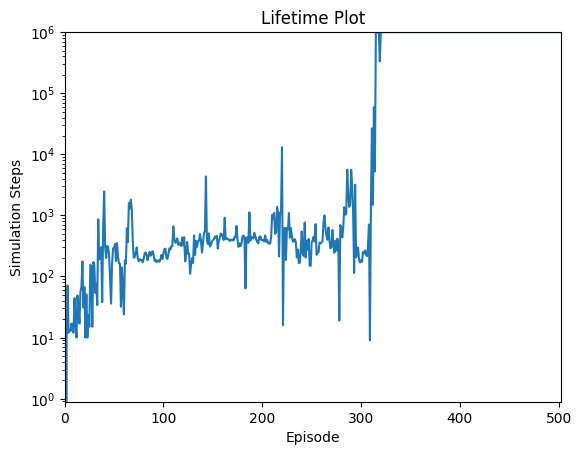

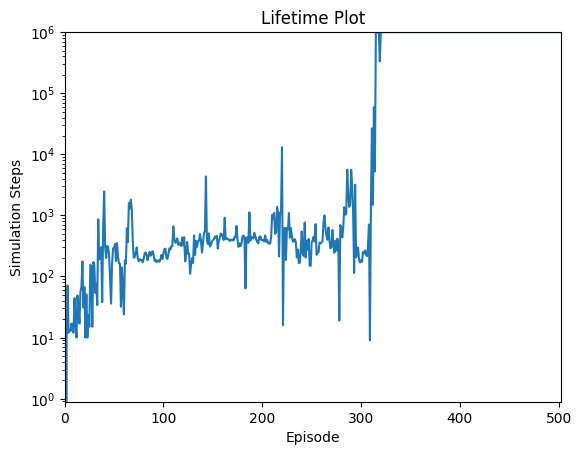

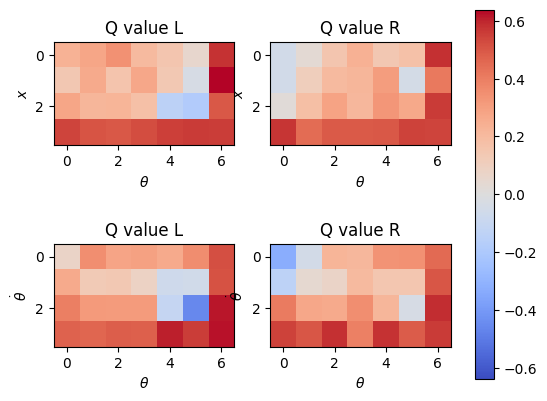

In [8]:
%pdb
r = Renderer(1200, 800, 600, 500, 400)
clock = pg.time.Clock()
running = True

p = Physics(0, (np.random.rand() - 1) / 10)

a = NonSpikingAgent(p.get_state(), 0.5, 0.9999999999999, 1, 0.995, 0.99)

plot = Non_Spiking_PlotRenderer()

episode: int = 0
steps_per_episode: int = 0
max_steps: int = 0

max_n_episodes = 500

window_size = 30
window = np.zeros(30)

plot_sim = False

while running:
    steps_per_episode += 1

    force = 0
    mouse_x = None

    # poll for events
    for event in pg.event.get():
        if event.type == pg.QUIT:
            running = False
            pg.quit()
            sys.exit()
            quit()
        elif event.type == pg.MOUSEBUTTONDOWN:
            mouse_x = r.get_relative_mouse_x(pg.mouse.get_pos()[0])
        elif event.type == pg.KEYDOWN:
            plot_sim ^= pg.key.get_pressed()[pg.K_SPACE]

    # agent chooses action, simulation is updated and reward is calculated
    force = 10 if a.choose_action() else -10
    theta, x = p.update(force, mouse_x)
    failure = a.update(p.get_state())

    if steps_per_episode > 1E6:
        # hard limit episodes to 1E6 iterations to keep them from running forever!!!
        # n.b. this does not affect learning!
        failure = True
        
    if episode > max_n_episodes:
        break

    if failure:
        p.reset()
        a.failure_reset(p.get_state())
        plot.update(a.get_episode(), steps_per_episode, a.boxes)
        window = np.roll(window, 1)
        window[0] = steps_per_episode
        steps_per_episode = 0
        episode += 1
    
    
    if plot_sim:
        r.draw_clear()
        r.draw_ground(0.2, "grey")
        r.draw_car(x)
        r.draw_pole(x, theta, 2*p.l, 0.02)
        r.draw_stats(theta*180/np.pi, p.w*180/np.pi, x, p.a, a.get_episode())
        r.display()

        clock.tick(50)  # limits FPS to 50
    
plot.update_q_value_heatmap(a)

<span style="background-color:yellow">TODO: Make plot of how much q values changed from before training to after training. Are there certain boxes that never get updated? i.e. is the state space (configuration space) adequately explored?</span>


# Spiking version

## Idea

The core principle of our SNN is to simulate the physics and neuron model in sequence, where the state at the end of a physics step is the input for the SNN and the resulting action at the end of a period of SNN simulation is the input to the next physics simulation. Both cycles are set to 40ms to provide the effect that they run simultaneously.
The model's structure consists of two layers of neurons. For each discrete state of the system, the input layer contains a single neuron corresponding to it. Neuromodulated synapses connect these to the output layer, which itself consists of two neuron groups interpreted as actions "move left" and "move right" respectively.

One simulation step of the SNN works as follows:
1. Get the current state of the cart pole and find the designated neuron that only fires when that state is reached.
2. Set a continuous firing rate for the simulation period on that neuron.
3. Determine which of the neuron groups in the output layer has fired more spikes at the end of the step.

# SNN Visualization

In [9]:
class Spiking_PlotRenderer():
    def __init__(self) -> None:
        self.fig, self.ax = plt.subplots(nrows=2)
        
        # Top plot for spikes
        self.ax[0].set_xlabel("Time [ms]")
        self.ax[0].set_yticks([])  # No Y-ticks
        self.ax[0].set_title("Input Spikes")
        self.ax[0].set_xlim(0, 40)  # Set the x-axis limits
        
        # Bottom plot for membrane potential
        self.ax[1].set_ylabel("V_m [mV]")
        self.ax[1].set_xlabel("Time [ms]")
        self.ax[1].set_xlim(0, 40)  # Set the x-axis limits
        self.ax[1].invert_yaxis()
        
        
    def update(self, data) -> None:
        if data is None: return

        self.ax[0].cla()
        self.ax[1].cla()

        self.ax[0].plot(data["input_spikes"]["times"], data["input_spikes"]["senders"], ".k", markersize=1)
        self.ax[0].set_xlim(np.min(data["multimeter_right_events"]["times"]), np.max(data["multimeter_right_events"]["times"]))
        
        self.ax[1].plot(data["multimeter_right_events"]["times"], data["multimeter_right_events"]["V_m"], 'r')
        self.ax[1].plot(data["multimeter_left_events"]["times"], data["multimeter_left_events"]["V_m"], 'b')
        self.ax[1].set_xlim(np.min(data["multimeter_right_events"]["times"]), np.max(data["multimeter_right_events"]["times"]))
        
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        
        display.clear_output(wait=True)
        display.display(self.fig)

## NESTML models

Neurons in the input layer will simply be spike generators (ignore_and_fire) that will fire spikes periodically with a given interval.

Neuron model used for the output layer will be iaf_psc_exp.

Input layer neurons are connected through output layer neurons through ``neuromodulated_stdp_synapse``.

In [10]:
# ... generate NESTML model code...

from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils

# generate and build code
input_layer_module_name, input_layer_neuron_model_name = \
   NESTCodeGeneratorUtils.generate_code_for("../../../models/neurons/ignore_and_fire_neuron.nestml")

# ignore_and_fire
output_layer_module_name, output_layer_neuron_model_name, output_layer_synapse_model_name = \
    NESTCodeGeneratorUtils.generate_code_for("iaf_psc_exp_neuron.nestml",
                                             "neuromodulated_stdp_synapse.nestml",
                                             post_ports=["post_spikes"],
                                             logging_level="DEBUG",
                                             codegen_opts={"delay_variable": {"neuromodulated_stdp_synapse": "d"},
                                                           "weight_variable": {"neuromodulated_stdp_synapse": "w"}})



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Dec 10 2024 12:04:47

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Dec 10 2024 12:04:47

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[12,ignore_and_fire_neuron_nestml, WARNING, [35:34;35:58]]: Model contains a call to fixed-timestep functions (``resolution()`` and/or ``steps()``). This restricts the model to being compatible only with fixed-timestep simulators. Consider eliminating ``resolution()`` and ``steps()`` from the model, and using ``times

INFO:Analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "g_e' = (-g_e) / tau_g",
            "initial_values": {
                "g_e": "0.0"
            }
        },
        {
            "expression": "V_m' = (g_e * (E_e - V_m) + E_l - V_m + I_e + I_stim) / tau_m",
            "initial_values": {
                "V_m": "E_l"
            }
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "E_e": "0",
        "E_l": "(-74)",
        "I_e": "0",
        "V_reset": "(-60)",
        "V_th": "(-54)",
        "s": "1000",
        "tau_g": "5",
        "tau_m": "10"
    }
}
INFO:Processing global options...
INFO:Processing input shapes...
INFO:
Processing differential-equation form shape g_e with defining expression = "(-g_e) / tau_g"
DEBUG:Splitting expression -g_e/tau_g (symbols [g_e])
DEBUG:	linear factors: Matrix([[-1/tau_g]])
DEBUG:	inhomogeneous term: 0.0
DEBUG:	nonlinear term: 0.0
DEBUG:Created Shape

[37,GLOBAL, INFO]: Successfully constructed neuron-synapse pair iaf_psc_exp_neuron_nestml__with_neuromodulated_stdp_synapse_nestml, neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml
[38,GLOBAL, INFO]: Analysing/transforming model 'iaf_psc_exp_neuron_nestml'
[39,iaf_psc_exp_neuron_nestml, INFO, [20:0;60:0]]: Starts processing of the model 'iaf_psc_exp_neuron_nestml'


DEBUG:	inhomogeneous term: 0.0
DEBUG:	nonlinear term: 0.0
INFO:Shape V_m: reconstituting expression E_e*g_e/tau_m + E_l/tau_m + I_e/tau_m + I_stim/tau_m - V_m*g_e/tau_m - V_m/tau_m
DEBUG:Splitting expression E_e*g_e/tau_m + E_l/tau_m + I_e/tau_m + I_stim/tau_m - V_m*g_e/tau_m - V_m/tau_m (symbols [g_e, V_m])
DEBUG:	linear factors: Matrix([[E_e/tau_m], [-1/tau_m]])
DEBUG:	inhomogeneous term: E_l/tau_m + I_e/tau_m + I_stim/tau_m
DEBUG:	nonlinear term: -V_m*g_e/tau_m
INFO:Saving dependency graph plot to /tmp/ode_dependency_graph_analytically_solvable_before_propagated.dot
DEBUG:os.makedirs('/tmp')
DEBUG:write lines to '/tmp/ode_dependency_graph_analytically_solvable_before_propagated.dot'
DEBUG:run [PosixPath('dot'), '-Kdot', '-Tpdf', '-O', 'ode_dependency_graph_analytically_solvable_before_propagated.dot']
INFO:Saving dependency graph plot to /tmp/ode_dependency_graph_analytically_solvable.dot
DEBUG:os.makedirs('/tmp')
DEBUG:write lines to '/tmp/ode_dependency_graph_analytically_solvable

DEBUG:run [PosixPath('dot'), '-Kdot', '-Tpdf', '-O', 'ode_dependency_graph_analytically_solvable.dot']
INFO:Generating numerical solver for the following symbols: g_e, V_m
DEBUG:Initializing system of shapes with x = Matrix([[g_e], [V_m]]), A = Matrix([[-1/tau_g, 0], [E_e/tau_m, -1/tau_m]]), b = Matrix([[0], [E_l/tau_m + I_e/tau_m + I_stim/tau_m]]), c = Matrix([[0], [-V_m*g_e/tau_m]])
INFO:Preserving expression for variable "g_e"
INFO:Preserving expression for variable "V_m"
INFO:In ode-toolbox: returning outdict = 
INFO:[
    {
        "initial_values": {
            "V_m": "E_l",
            "g_e": "0.0"
        },
        "parameters": {
            "E_e": "0",
            "E_l": "-74.0000000000000",
            "I_e": "0",
            "tau_g": "5.00000000000000",
            "tau_m": "10.0000000000000"
        },
        "solver": "numeric",
        "state_variables": [
            "g_e",
            "V_m"
        ],
        "update_expressions": {
            "V_m": "(g_e * (E_e -

DEBUG:Initializing system of shapes with x = Matrix([[g_e], [V_m], [post_trace__for_neuromodulated_stdp_synapse_nestml]]), A = Matrix([[-1/tau_g, 0, 0], [E_e/tau_m, -1/tau_m, 0], [0, 0, -1/tau_tr_post__for_neuromodulated_stdp_synapse_nestml]]), b = Matrix([[0], [E_l/tau_m + I_e/tau_m + I_stim/tau_m], [0]]), c = Matrix([[0], [-V_m*g_e/tau_m], [0]])
INFO:Finding analytically solvable equations...
INFO:Saving dependency graph plot to /tmp/ode_dependency_graph.dot
DEBUG:os.makedirs('/tmp')
DEBUG:write lines to '/tmp/ode_dependency_graph.dot'
DEBUG:run [PosixPath('dot'), '-Kdot', '-Tpdf', '-O', 'ode_dependency_graph.dot']
INFO:Shape g_e: reconstituting expression -g_e/tau_g
DEBUG:Splitting expression -g_e/tau_g (symbols [g_e, V_m, post_trace__for_neuromodulated_stdp_synapse_nestml])
DEBUG:	linear factors: Matrix([[-1/tau_g], [0], [0]])
DEBUG:	inhomogeneous term: 0.0
DEBUG:	nonlinear term: 0.0
INFO:Shape V_m: reconstituting expression E_e*g_e/tau_m + E_l/tau_m + I_e/tau_m + I_stim/tau_m - V_

[40,GLOBAL, INFO]: Analysing/transforming model 'iaf_psc_exp_neuron_nestml__with_neuromodulated_stdp_synapse_nestml'
[41,iaf_psc_exp_neuron_nestml__with_neuromodulated_stdp_synapse_nestml, INFO, [20:0;60:0]]: Starts processing of the model 'iaf_psc_exp_neuron_nestml__with_neuromodulated_stdp_synapse_nestml'


INFO:Saving dependency graph plot to /tmp/ode_dependency_graph_analytically_solvable.dot
DEBUG:os.makedirs('/tmp')
DEBUG:write lines to '/tmp/ode_dependency_graph_analytically_solvable.dot'
DEBUG:run [PosixPath('dot'), '-Kdot', '-Tpdf', '-O', 'ode_dependency_graph_analytically_solvable.dot']
INFO:Generating propagators for the following symbols: g_e, post_trace__for_neuromodulated_stdp_synapse_nestml
DEBUG:Initializing system of shapes with x = Matrix([[g_e], [post_trace__for_neuromodulated_stdp_synapse_nestml]]), A = Matrix([[-1/tau_g, 0], [0, -1/tau_tr_post__for_neuromodulated_stdp_synapse_nestml]]), b = Matrix([[0], [0]]), c = Matrix([[0], [0]])
DEBUG:System of equations:
DEBUG:x = Matrix([[g_e], [post_trace__for_neuromodulated_stdp_synapse_nestml]])
DEBUG:A = Matrix([
[-1/tau_g,                                                      0],
[       0, -1/tau_tr_post__for_neuromodulated_stdp_synapse_nestml]])
DEBUG:b = Matrix([[0], [0]])
DEBUG:c = Matrix([[0], [0]])
INFO:update_expr[g_e] 

DEBUG:Splitting expression -post_trace__for_neuromodulated_stdp_synapse_nestml/tau_tr_post__for_neuromodulated_stdp_synapse_nestml (symbols [g_e, V_m, post_trace__for_neuromodulated_stdp_synapse_nestml, g_e, V_m, post_trace__for_neuromodulated_stdp_synapse_nestml])
DEBUG:	linear factors: Matrix([[0], [0], [-1/tau_tr_post__for_neuromodulated_stdp_synapse_nestml], [0], [0], [0]])
DEBUG:	inhomogeneous term: 0.0
DEBUG:	nonlinear term: 0.0
DEBUG:Created Shape with symbol post_trace__for_neuromodulated_stdp_synapse_nestml, derivative_factors = [-1/tau_tr_post__for_neuromodulated_stdp_synapse_nestml], inhom_term = 0.0, nonlin_term = 0
INFO:	Returning shape: Shape "post_trace__for_neuromodulated_stdp_synapse_nestml" of order 1
INFO:Shape g_e: reconstituting expression -g_e/tau_g
DEBUG:Splitting expression -g_e/tau_g (symbols Matrix([[g_e], [V_m], [post_trace__for_neuromodulated_stdp_synapse_nestml]]))
DEBUG:	linear factors: Matrix([[-1/tau_g], [0], [0]])
DEBUG:	inhomogeneous term: 0.0
DEBUG:	n

DEBUG:	inhomogeneous term: 0.0
DEBUG:	nonlinear term: 0.0
DEBUG:Initializing system of shapes with x = Matrix([[pre_trace]]), A = Matrix([[-1/tau_tr_pre]]), b = Matrix([[0]]), c = Matrix([[0]])
INFO:Finding analytically solvable equations...
INFO:Saving dependency graph plot to /tmp/ode_dependency_graph.dot
DEBUG:os.makedirs('/tmp')
DEBUG:write lines to '/tmp/ode_dependency_graph.dot'
DEBUG:run [PosixPath('dot'), '-Kdot', '-Tpdf', '-O', 'ode_dependency_graph.dot']
INFO:Shape pre_trace: reconstituting expression -pre_trace/tau_tr_pre
DEBUG:Splitting expression -pre_trace/tau_tr_pre (symbols [pre_trace])
DEBUG:	linear factors: Matrix([[-1/tau_tr_pre]])
DEBUG:	inhomogeneous term: 0.0
DEBUG:	nonlinear term: 0.0
INFO:Saving dependency graph plot to /tmp/ode_dependency_graph_analytically_solvable_before_propagated.dot
DEBUG:os.makedirs('/tmp')
DEBUG:write lines to '/tmp/ode_dependency_graph_analytically_solvable_before_propagated.dot'
DEBUG:run [PosixPath('dot'), '-Kdot', '-Tpdf', '-O', 'ode

[42,GLOBAL, INFO]: Analysing/transforming synapse neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml.
[43,neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml, INFO, [8:0;55:0]]: Starts processing of the model 'neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml'


DEBUG:System of equations:
DEBUG:x = Matrix([[pre_trace]])
DEBUG:A = Matrix([[-1/tau_tr_pre]])
DEBUG:b = Matrix([[0]])
DEBUG:c = Matrix([[0]])
INFO:update_expr[pre_trace] = __P__pre_trace__pre_trace*pre_trace
INFO:In ode-toolbox: returning outdict = 
INFO:[
    {
        "initial_values": {
            "pre_trace": "0.0"
        },
        "parameters": {
            "tau_tr_pre": "20.0000000000000"
        },
        "propagators": {
            "__P__pre_trace__pre_trace": "exp(-__h/tau_tr_pre)"
        },
        "solver": "analytical",
        "state_variables": [
            "pre_trace"
        ],
        "update_expressions": {
            "pre_trace": "__P__pre_trace__pre_trace*pre_trace"
        }
    }
]


[44,GLOBAL, INFO]: Rendering template /home/charl/julich/nestml-fork-AlexisWis-cart_pole_tutorial/nestml/doc/tutorials/cart_pole_reinforcement_learning/target/iaf_psc_exp_neuron_nestml.cpp
[45,GLOBAL, INFO]: Rendering template /home/charl/julich/nestml-fork-AlexisWis-cart_pole_tutorial/nestml/doc/tutorials/cart_pole_reinforcement_learning/target/iaf_psc_exp_neuron_nestml.h
[46,iaf_psc_exp_neuron_nestml, INFO, [20:0;60:0]]: Successfully generated code for the model: 'iaf_psc_exp_neuron_nestml' in: '/home/charl/julich/nestml-fork-AlexisWis-cart_pole_tutorial/nestml/doc/tutorials/cart_pole_reinforcement_learning/target' !
[47,GLOBAL, INFO]: Rendering template /home/charl/julich/nestml-fork-AlexisWis-cart_pole_tutorial/nestml/doc/tutorials/cart_pole_reinforcement_learning/target/iaf_psc_exp_neuron_nestml__with_neuromodulated_stdp_synapse_nestml.cpp
[48,GLOBAL, INFO]: Rendering template /home/charl/julich/nestml-fork-AlexisWis-cart_pole_tutorial/nestml/doc/tutorials/cart_pole_reinforcement_

In file included from /home/charl/julich/nestml-fork-AlexisWis-cart_pole_tutorial/nestml/doc/tutorials/cart_pole_reinforcement_learning/target/nestml_0c5edfeaeaa147b79fe91f18fa1f2587_module.cpp:36:
/home/charl/julich/nestml-fork-AlexisWis-cart_pole_tutorial/nestml/doc/tutorials/cart_pole_reinforcement_learning/target/neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml.h: In instantiation of ‘nest::neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml<targetidentifierT>::neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml() [with targetidentifierT = nest::TargetIdentifierPtrRport]’:
/home/charl/julich/nest-simulator-install/include/nest/connector_model.h:164:25:   required from ‘nest::GenericConnectorModel<ConnectionT>::GenericConnectorModel(std::string) [with ConnectionT = nest::neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml<nest::TargetIdentifierPtrRport>; std::string = std::__cxx11::basic_string<char>]’
/home/charl/julich

/home/charl/julich/nestml-fork-AlexisWis-cart_pole_tutorial/nestml/doc/tutorials/cart_pole_reinforcement_learning/target/neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml.h: In instantiation of ‘bool nest::neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml<targetidentifierT>::send(nest::Event&, size_t, const nest::neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestmlCommonSynapseProperties&) [with targetidentifierT = nest::TargetIdentifierPtrRport; size_t = long unsigned int]’:
/home/charl/julich/nest-simulator-install/include/nest/connector_base.h:391:22:   required from ‘void nest::Connector<ConnectionT>::send_to_all(size_t, const std::vector<nest::ConnectorModel*>&, nest::Event&) [with ConnectionT = nest::neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml<nest::TargetIdentifierPtrRport>; size_t = long unsigned int]’
/home/charl/julich/nest-simulator-install/include/nest/connector_base.h:383:3:   required from here
/home/c

[100%] Linking CXX shared module nestml_0c5edfeaeaa147b79fe91f18fa1f2587_module.so
[100%] Built target nestml_0c5edfeaeaa147b79fe91f18fa1f2587_module_module
[100%] Built target nestml_0c5edfeaeaa147b79fe91f18fa1f2587_module_module
Install the project...
-- Install configuration: ""
-- Installing: /tmp/nestml_target_yzohwcb8/nestml_0c5edfeaeaa147b79fe91f18fa1f2587_module.so


In [9]:
class SpikingAgent(Agent):    
    def __init__(self, initial_state: Tuple[float,float,float,float], gamma) -> None:
        super().__init__(initial_state)
        self.gamma = gamma
        self.construct_neural_network()
        self.Q_left = None
        self.Q_right = None
        self.Q_left_prev = None
        self.Q_right_prev = None
        self.scale_n_output_spikes_to_Q_value = .1
    
    def get_state_neuron(self, state) -> int:
        idx = 0
        thresholds = [self.x_thresholds, self.theta_thresholds, self.v_thresholds, self.w_thresholds]
        for dim, val, thresh in zip(self.dimensions, state, thresholds):
            i = self.discretize(val,thresh)
            if i == -1:
                return -1
            idx = idx * dim + i

        return idx
    
    def construct_neural_network(self):
        nest.ResetKernel()
        nest.Install(input_layer_module_name)   # makes the generated NESTML model available
        nest.Install(output_layer_module_name)   # makes the generated NESTML model available

        input_size = self.dimensions[0] * self.dimensions[1] * self.dimensions[2] * self.dimensions[3]
        self.input_population = nest.Create(input_layer_neuron_model_name, input_size)
        
        self.output_population_left = nest.Create(output_layer_neuron_model_name, 10)
        self.output_population_right = nest.Create(output_layer_neuron_model_name, 10)
        
        self.spike_recorder_input = nest.Create("spike_recorder")
        nest.Connect(self.input_population, self.spike_recorder_input)

        self.multimeter_left = nest.Create('multimeter', 1, {'record_from': ['V_m']})
        nest.Connect(self.multimeter_left, self.output_population_left)
        self.multimeter_right = nest.Create('multimeter', 1, {'record_from': ['V_m']})
        nest.Connect(self.multimeter_right, self.output_population_right)

        #the random weights do very weird stuff...
        nest.Connect(self.input_population, self.output_population_left, syn_spec={"synapse_model": output_layer_synapse_model_name,})
                                                                                   #'weight': nest.random.normal(mean=0., std=1.),})
        nest.Connect(self.input_population, self.output_population_right, syn_spec={"synapse_model": output_layer_synapse_model_name,})
                                                                                    #'weight': nest.random.normal(mean=0., std=1.),})

        self.output_population_spike_recorder_left = nest.Create("spike_recorder")
        nest.Connect(self.output_population_left, self.output_population_spike_recorder_left)

        self.output_population_spike_recorder_right = nest.Create("spike_recorder")
        nest.Connect(self.output_population_right, self.output_population_spike_recorder_right)

    #returns 0 if the action is "left", else "1"
    def choose_action(self, Q_left, Q_right) -> int:
        return Q_left > Q_right

    def compute_Q_values(self) -> None:
        n_output_spikes_left = self.output_population_spike_recorder_left.n_events
        n_output_spikes_right = self.output_population_spike_recorder_right.n_events
 
        self.output_population_spike_recorder_left.n_events = 0
        self.output_population_spike_recorder_right.n_events = 0
        
        self.Q_left_prev = self.Q_left
        self.Q_right_prev = self.Q_right

        # still need to get scale
        self.Q_left = self.scale_n_output_spikes_to_Q_value * n_output_spikes_left
        self.Q_right = self.scale_n_output_spikes_to_Q_value * n_output_spikes_right

    # update Q_value using TD-Error with previous Q_value and reward = 0
    # cooldown_time in case the SNN doesn't need 40ms to update
    def failure_reset(self, cooldown_time) -> None:
        # if for some reason the simulation terminates super fast
        if self.Q_left_prev == None and self.Q_right_prev == None:
            return
        # what would we mean by that? negative dopamine is biologically inaccurate
        # inhibitory neuromodulators?
        if self.choose_action(self.Q_left_prev, self.Q_right_prev):
            syn = nest.GetConnections(source=self.input_population, target=self.output_population_right)
            syn.n = -self.Q_right
        else:
            syn = nest.GetConnections(source=self.input_population, target=self.output_population_left)
            syn.n = -self.Q_left
        nest.Simulate(cooldown_time)
        
        self.episode += 1

    def update(self, next_state: Tuple[float,float,float,float], step_duration: float) -> Tuple[int, dict]:
        
        # make the correct input neuron fire
        self.input_population.firing_rate = 0.
        neuron_id = self.get_state_neuron(next_state)

        # if state was a failure
        if neuron_id == -1:
            self.failure_reset(SpikingAgent.cycle_period)
            return -1, None
        
        self.input_population[neuron_id].firing_rate = 5000. # XXX: unrealistically high value used in Liu & Pan
        self.multimeter_left.n_events = 0
        self.multimeter_right.n_events = 0
        self.spike_recorder_input.n_events = 0
        
        # simulate for one step
        nest.Simulate(step_duration)
        
        #passed onto Spiking_Plot_Renderer()
        plot_data = {
            "input_spikes": nest.GetStatus(self.spike_recorder_input, keys="events")[0],
            "multimeter_right_events": self.multimeter_right.get("events"),
            "multimeter_left_events": self.multimeter_left.get("events")
        }

        self.compute_Q_values()

        # set new dopamine concentration on the synapses
        # PROBLEM: HOW DO WE HANDLE FAILURE? The physics simulation immediately resets after it.
        # Perhaps run the simulation without spiking to let the weights update? (BVogler)

        # update Q_value using TD-Error with previous Q_value and reward = 1
        if self.Q_left_prev != None and self.Q_right_prev != None:
            R = 1.
            if self.choose_action(self.Q_left_prev, self.Q_right_prev):
                syn = nest.GetConnections(source=self.input_population, target=self.output_population_right)
                syn.n = self.gamma * self.Q_right + R - self.Q_right_prev
            else:
                syn = nest.GetConnections(source=self.input_population, target=self.output_population_left)
                syn.n = self.gamma * self.Q_left + R - self.Q_left_prev
        
        # 0 if action is "left", else 1
        return self.choose_action(self.Q_left, self.Q_right), plot_data
        

# Executing spiking version

The main loop looks like this: for every iteration of the loop (for every "cycle" or "step"):

- set the rate of the input neurons to the current state of the system
- run the SNN with this input state s_n for a period of time (cycle time, in BVogler's thesis: 40 ms)
- obtain the Q(sn, a) values, by counting nr of spikes in output population over this cycle period
- choose action $a_n$ on the basis of Q-values
- run the environment for the same cycle time (40 ms) to obtain next state $s_{n+1}$
- compute reward on the basis of the last taken action (????)

In [11]:
step_duration = 40.   # alternate between physics and controller every this often [ms] 

r = Renderer(1200, 800, 600, 500, 400)
clock = pg.time.Clock()
running = True

p = Physics(0, (np.random.rand() - 1) / 10)

a = SpikingAgent(p.get_state(), 0.98)

plot = Spiking_PlotRenderer()

episode: int = 0
steps_per_episode: int = 0

window_size = 30
window = np.zeros(30)

max_n_episodes = 500
plot_sim = False

while running:
    steps_per_episode += 1
    force = 0
    mouse_x = None

    # poll for events
    for event in pg.event.get():
        if event.type == pg.QUIT:
            running = False
            pg.quit()
            sys.exit()
            quit()
        elif event.type == pg.MOUSEBUTTONDOWN:
            mouse_x = r.get_relative_mouse_x(pg.mouse.get_pos()[0])
        elif event.type == pg.KEYDOWN:
            # controls if simulation should be shown or not
            plot_sim ^= pg.key.get_pressed()[pg.K_SPACE]

    # simulate physics for ``step_duration``
    for i in range(step_duration / p.dt):
        theta, x = p.update(0, mouse_x)

    # simulate SNN, choose action
    action, plot_data = a.update(p.get_state(), step_duration=step_duration)
    if action == -1:
        p.reset()
        a.failure_reset(SpikingAgent.cycle_period)
        window = np.roll(window, 1)
        window[0] = steps_per_episode
        steps_per_episode = 0
        episode += 1
    else:
        force = 10 if action else -10
        theta, x = p.update(force, mouse_x)

        if plot_sim:
            plot.update(plot_data)
    
    if steps_per_episode > 1E6:
        # hard limit episodes to 1E6 iterations to keep them from running forever!!!
        # n.b. this does not affect learning!
        failure = True
        
    if episode > max_n_episodes:
        break

    if plot_sim:
        r.draw_clear()
        r.draw_ground(0.2, "grey")
        r.draw_car(x)
        r.draw_pole(x, theta, 2*p.l, 0.02)
        r.draw_stats(theta*180/np.pi, p.w*180/np.pi, x, p.a, a.get_episode())
        r.display()

        clock.tick(50)  # limits FPS to 50

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/homebrew/anaconda3/envs/cart_pole/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/homebrew/anaconda3/envs/cart_pole/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/homebrew/anaconda3/envs/cart_pole/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplo

: 

## Citations

[1] Liu Y, Pan W. Spiking Neural-Networks-Based Data-Driven Control. Electronics. 2023; 12(2):310. https://doi.org/10.3390/electronics12020310 

## Acknowledgements

The authors would like to thank Prof. Wei Pan and Dr. Yuxiang Liu for kindly providing ...